# Sine Wave Example

For an interactive version of this example, see this [Observable notebook](https://observablehq.com/@dkirkby/boed).

This notebook performs similar calculations but with some important differences:
 - It is python code, not javascript, so significantly faster.
 - It uses the general-purpose [bayesdesign](https://pypi.org/project/bayesdesign) package,
   while the Observable notebook is hardcoded for this sine wave example.
 - It supports multi-dimensional grids for the parameters, features and designs, limited only by the available memory.

 To install the latest version of the [bayesdesign](https://pypi.org/project/bayesdesign) package, use:
 ```
 pip install bayesdesign
 ```
 Note that the python module included with this package uses the shorter name `bed` (for Bayesian Experiment Design).

In [1]:
try:
    import bed
except ImportError:
    %pip install bayesdesign

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from bed.grid import Grid
from bed.design import ExperimentDesigner

## Problem Setup

Define the experimental design space. A "design" in this problem consists of a choice of observation time $t_\text{obs}$.

In [5]:
designs = Grid(t_obs=np.linspace(0, 5, 101))

Define the data features. The data consists of a measurement $y_\text{obs}$ at $t_\text{obs}$.

In [6]:
features = Grid(y_obs=np.linspace(-1.25, 1.25, 100))

Define the parameters:
 - amplitude $A$
 - frequency $\omega$
 - offset $t_0$

for the model $y(t) = A \sin\left[ \omega (t - t_0) \right]$. In this example, only the frequency is unknown.

In [7]:
params = Grid(amplitude=1, frequency=np.linspace(0.2, 2.0, 181), offset=0)

Tabulate the likelihood $P(y_\text{obs}\mid A, \omega, t_0, t_\text{obs})$ for all possible designs $t_\text{obs}$. We assume a Gaussian distribution of measurements with mean $y(t)$ and fixed standard deviation $\sigma_y$.

In [8]:
def unnorm_lfunc(params, features, designs, **kwargs):
    y_mean = params.amplitude * np.sin(params.frequency * (designs.t_obs - params.offset))
    y_diff = features.y_obs - y_mean
    likelihood = np.exp(-0.5 * (y_diff / kwargs["sigma_y"]) ** 2)
    return likelihood

The likelihood is a large array whose size limits how big a problem we can tackle in practice. It is indexed over the parameters, features, and designs.

Initialize an `ExperimentDesigner` with the grids and likelihood for this problem:

In [9]:
designer = ExperimentDesigner(params, features, designs, unnorm_lfunc, lfunc_args={'sigma_y': 0.1})

## Calculate the Optimal First Measurement

What initial measurement of this sine wave will provide the most information about the unknown parameters (just the frequency in this example)? In order to quantify this, via the *expected information gain* (EIG), we must first specify our prior knowledge of the parameters.

Tabulate the prior on our parameters grid $P(A,\omega,t_0)$ which we take to be flat:

In [10]:
prior = np.ones(params.shape)
params.normalize(prior);

Calculate the expected information gain (EIG) for all possible experiment designs (i.e. values of $t_{obs}$):

In [11]:
best = designer.calculateEIG(prior)
designer.describe()

GRID           designs [101:t_obs]
GRID          features [100:y_obs]
GRID        parameters [1:amplitude, 181:frequency, 1:offset]
ARRAY            prior (1, 181, 1)                      0.0 Mb
ARRAY       likelihood (100, 101, 1, 181, 1)           13.9 Mb
ARRAY         marginal (100, 101)                       0.1 Mb
ARRAY               IG (100, 101)                       0.1 Mb
ARRAY              EIG (101,)                           0.0 Mb


The `calculateEIG` method returns a dictionary of design variables and their corresponding values where the EIG is maximized. In this case, we just have a single design variable:

In [12]:
best

{'t_obs': 3.5}

Plot the EIG for all possible designs (observation times). The value is zero at $t_{obs} = 0$ since all possible models pass through $y(0) = 0$. The exact shape of this curve depends on the assumed prior, the range of allowed frequencies, and the assumed (fixed) offset and measurement uncertainty (relative to the fixed amplitude). The best possible measurement is at $t_{obs} = 3.5$, but any measurement at $t_{obs} \gtrsim 2.5$ is almost optimal.

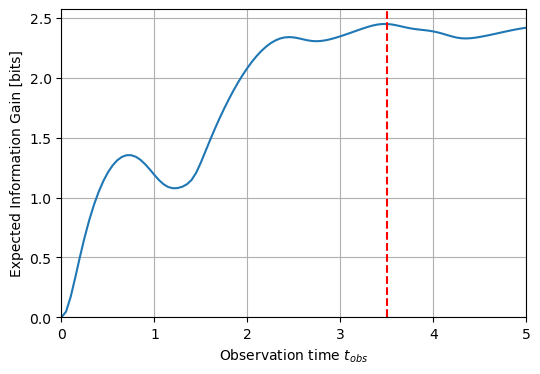

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(designs.t_obs, designer.EIG)
ax.set(xlabel='Observation time $t_{obs}$', xlim=designs.extent('t_obs'),
       ylabel='Expected Information Gain [bits]', ylim=(0, None))
ax.axvline(best['t_obs'], color='red', linestyle='--')
ax.grid();

## Calcuate An Optimal Second Measurement

The procedure for calculating subsequent optimal measurements is essentially the same. The only difference is that the original prior is replaced by a posterior probability density on the parameters, conditioned on the measurements taken so far.

Therefore we must specify the time $t_{obs}$ and result $y_{obs}$ of the first measurement in order to then calculate an optimal second measurement. Let's assume we make our first measurement at the optimal time $t_{obs} = 3.5$, then how likely are different measurement results $y_{obs}$? This quantity is already computed and stored as `designer.marginal` for all possible measurement times, and plotted below for $t_{obs} = 3.5$. Note that $|y_{obs}| > 1$ is possible because of the Gaussian measurement errors.

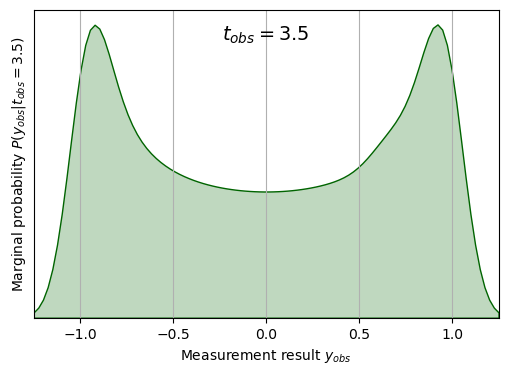

In [14]:
i_best = np.argmax(designer.EIG)
fig, ax = plt.subplots(figsize=(6, 4))
ax.fill_between(features.y_obs, designer.marginal[:, i_best], ec='#006400', fc='#00640040')
ax.set(xlabel='Measurement result $y_{obs}$', xlim=features.extent('y_obs'),
       ylabel=f'Marginal probability $P(y_{{obs}}|t_{{obs}}={best["t_obs"]})$', ylim=(0, None), yticks=[])
ax.text(0.5, 0.9, f'$t_{{obs}}={best["t_obs"]}$', fontsize=14, transform=ax.transAxes, ha='center')
ax.grid();

Let's assume that our initial measurement at $t_{obs} = 3.5$ yields $y_{obs} = -0.5$, then the resulting posterior probability density is also already computed and stored as `designer.posterior` for all possible values of $t_{obs}$ and $y_{obs}$. The plot below compares the (assumed flat) prior with the posterior for our assumed measurement. Note that the posterior is multi-model, i.e. there are two distinct allowed regions in the parameter space.

In [15]:
posterior = designer.get_posterior(t_obs=best['t_obs'], y_obs=-0.5).ravel()
freq = params.frequency.ravel()

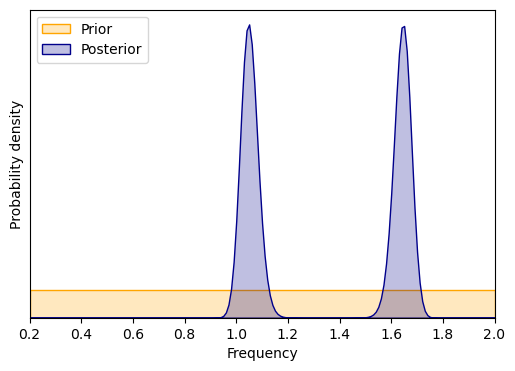

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.fill_between(freq, prior.ravel(), ec='#FFA500', fc='#FFA50040', label='Prior')
ax.fill_between(freq, posterior, ec='#00008B', fc='#00008B40', label='Posterior')
ax.set(xlabel='Frequency', xlim=params.extent('frequency'),
       ylabel='Probability density', ylim=(0, None), yticks=[])
ax.legend(loc='upper left');


Finally, to calculate the optimal second (or next) measurement, we call `designer.update` and specify our initial (or previous) measurement:

In [17]:
new_best = designer.update(t_obs=best['t_obs'], y_obs=-0.5)
print(new_best)

{'t_obs': 3.85}


A plot of the updated EIG shows a sharp dip around the time of the first measurement, indicating that a repeat measurement provides minimal new information (but non-zero since it still helps to average out the noise). The EIG for $t_{obs} \gtrsim 1.5$ is at least 1 bit, where 1 bit is the expected gain from resolving the two-fold ambiguity in the posterior plot above.

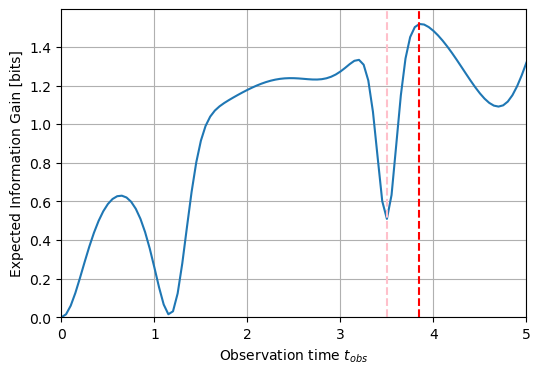

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(designs.t_obs, designer.EIG)
ax.set(xlabel='Observation time $t_{obs}$', xlim=designs.extent('t_obs'),
       ylabel='Expected Information Gain [bits]', ylim=(0, None))
ax.axvline(best['t_obs'], color='pink', linestyle='--')
ax.axvline(new_best['t_obs'], color='red', linestyle='--')
ax.grid();